<a href="https://colab.research.google.com/github/intTing/1/blob/main/3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
A = np.array([[1, 0, 0.0],
              [0, 1, 0],
              [0.0, 0, 1]])

B = np.array([[1.0, -0.5, 0.0],
              [-0.5, 2.5, 2],
              [0.0, 2, 2]])

In [2]:
def _sym(A):
    return 0.5*(A + A.T) # Return the symmetric matrix (A + A^T)/2

# Determine whether a matrix is ​​symmetric positive definite (SPD)
def is_spd(A, tol=1e-12):
   # 1) Check for symmetry
    if not np.allclose(A, A.T, atol=1e-12):
        return False
    w = np.linalg.eigvalsh(A) # 2) Check if the eigenvalue is positive
    return np.all(w > tol)

def eigh_spd(A):
    """Eigendecomposition of a symmetric positive definite matrix (ascending eigenvalues)"""
    w, V = np.linalg.eigh(_sym(A))
    w = np.maximum(w, 1e-15)  # Numerical safety
    return w, V

def logm_spd(A):
    w, V = eigh_spd(A)
    """Logarithm of the SPD matrix: A = V diag(λ) V^T → log(A) = V diag(log λ) V^T"""
    return V @ np.diag(np.log(w)) @ V.T

def expm_sym(S):
    w, V = np.linalg.eigh(_sym(S))
    """Exponential mapping of symmetric matrices: S = V diag(σ) V^T → exp(S) = V diag(exp σ) V^T"""
    return V @ np.diag(np.exp(w)) @ V.T

def sqrtm_spd(A):
    w, V = eigh_spd(A)
    """Square root of the SPD matrix"""
    return V @ np.diag(np.sqrt(w)) @ V.T

def invsqrtm_spd(A):
    w, V = eigh_spd(A)
    """Inverse square root of the SPD matrix"""
    return V @ np.diag(1.0/np.sqrt(w)) @ V.T

# log / exp of SO(3) (Rodrigues' rotation formula)
# Convert vector a = (ax,ay,az) to a 3x3 antisymmetric matrix
def _skew_from_vec(a):
    ax, ay, az = a
    return np.array([[0, -az, ay],
                     [az, 0, -ax],
                     [-ay, ax, 0]], dtype=float)

# Antisymmetric matrix → corresponding vector
def _vec_from_skew(A):
    return np.array([A[2,1], A[0,2], A[1,0]], dtype=float)

"""
Input: 3x3 antisymmetric matrix A
Output: rotation matrix R = exp(A)
"""
def exp_SO3(A):
    """A is a 3×3 antisymmetric matrix; returns exp(A) ∈ SO(3)"""
     # Orthogonalize + ensure det=1
    A = 0.5 * (A - A.T)     # <-- Make sure it's exactly the antisymmetric part of A, not doubled
    a = _vec_from_skew(A)
    theta = np.linalg.norm(a)
    I = np.eye(3)
    if theta < 1e-12:
        return I + A
    K = A / theta           # hat(u)
    s, c = np.sin(theta), np.cos(theta)
    return I + s*K + (1.0 - c)*(K @ K)
    # Rodrigues’ rotation formula
    # This ensures that the output matrix is ​​an orthogonal matrix and det=1, which means it is a legal three-dimensional rotation.

def log_SO3(R):
    U, _, Vt = np.linalg.svd(R)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    tr = np.trace(R)
    cos_theta = (tr - 1.0)/2.0
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    if theta < 1e-12: # Approximately zero rotation
        return np.zeros((3,3))
    if np.pi - theta < 1e-7: # Close to 180° Special treatment
        M = 0.5*(R + np.eye(3))
        v = np.array([np.sqrt(max(M[0,0], 0.0)),
                      np.sqrt(max(M[1,1], 0.0)),
                      np.sqrt(max(M[2,2], 0.0))])
        if np.linalg.norm(v) < 1e-8:
            v = np.array([R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]])
            if np.linalg.norm(v) < 1e-8:
                v = np.array([1.0,0.0,0.0])
        v = v/np.linalg.norm(v)
        return _skew_from_vec(v*theta)
    A = (theta/(2.0*np.sin(theta))) * (R - R.T)
    return A


# 1) Frobenius (Euclidean)

def distance_frobenius(A, B):
    return np.linalg.norm(_sym(B - A), ord='fro')

def geodesic_frobenius_3d(A, B, t):
    return _sym((1.0 - t)*A + t*B)

# Returns the Frobenius geodesic path
def frobenius_path(A, B, num=50):
    ts = np.linspace(0,1,num)
    return np.stack([geodesic_frobenius_3d(A,B,t) for t in ts])


# 2) Log-Euclidean
def distance_logeuclidean(A, B):
    return np.linalg.norm(logm_spd(B) - logm_spd(A), ord='fro')

# Log–Euclidean Geodesic: Linear Interpolation in Log Space
def geodesic_logeuclidean_3d(A, B, t):
    LA, LB = logm_spd(A), logm_spd(B)
    return expm_sym((1.0 - t)*LA + t*LB)

def logeuclidean_path(A, B, num=50):
    ts = np.linspace(0,1,num)
    return np.stack([geodesic_logeuclidean_3d(A,B,t) for t in ts])


# 3) Affine-Invariant
def distance_affine_invariant(A, B):
    Ais = invsqrtm_spd(A)
    C = Ais @ B @ Ais
    return np.linalg.norm(logm_spd(C), ord='fro')

# Affine–Invariant Geodesic formula
def geodesic_affine_invariant_3d(A, B, t):
    As = sqrtm_spd(A)
    Ais = invsqrtm_spd(A)
    Clog = logm_spd(Ais @ B @ Ais)
    return _sym(As @ expm_sym(t*Clog) @ As)

def affine_invariant_path(A, B, num=50):
    ts = np.linspace(0,1,num)
    return np.stack([geodesic_affine_invariant_3d(A,B,t) for t in ts])


# 4) Scale-Rotation
# Signed matrix under permutation (det=+1)
def _even_sign_diags():
    return [
        np.diag([ 1, 1, 1]),
        np.diag([-1,-1, 1]),
        np.diag([-1, 1,-1]),
        np.diag([ 1,-1,-1]),
    ]

# Returns 6 permutation matrices
def _permutation_mats():
    perms = []
    for p in [(0,1,2),(0,2,1),(1,0,2),(1,2,0),(2,0,1),(2,1,0)]:
        P = np.zeros((3,3))
        for i,j in enumerate(p):
            P[j,i] = 1.0
        perms.append((p,P))
    return perms

# Return all 24 (U,d) versions of matrix A
def _all_versions_3x3(A):
    d, U = eigh_spd(A)
    versions = []
    for p, P in _permutation_mats():
        Uperm = U[:, list(p)]
        dperm = d[list(p)]
        for S in _even_sign_diags():
            Uv = Uperm @ S
            versions.append((Uv, dperm))
    return versions

# distance formula on (SO×Diag^+)
def _product_geodesic_distance(U1, d1, U2, d2, k=1.0):
    R = U2 @ U1.T
    A = log_SO3(R) # Rotation part
    rot2 = 0.5 * np.linalg.norm(A, ord='fro')**2
    L = np.log(d2) - np.log(d1) # Scaling part
    diag2 = np.sum(L**2)
    return np.sqrt(k*rot2 + diag2), A, L

# Find the optimal version pair of A and B to get the shortest SR distance
def _scale_rotation_min_pair(A, B, k=1.0):
    best = (np.inf, None, None, None)
    versA = _all_versions_3x3(A)
    versB = _all_versions_3x3(B)
    for (U1,d1) in versA:
        for (U2,d2) in versB:
            dist, Aso, Ldiag = _product_geodesic_distance(U1,d1,U2,d2,k=k)
            if dist < best[0]:
                best = (dist, (U1,d1), (U2,d2), (Aso, Ldiag))
    return best

def distance_scale_rotation(A, B, k=1.0):
    assert is_spd(A) and is_spd(B)
    dist, _, _, _ = _scale_rotation_min_pair(A,B,k=k)
    return dist

def curve_scale_rotation_3d(A, B, t, k=1.0, force_B=False):
    if not force_B:
        # Original optimal version search
        dist, (U1,d1), (U2,d2), (Aso, Ldiag) = _scale_rotation_min_pair(A,B,k=k)
    else:
        # Fixed the decomposed version of B
        d1, U1 = eigh_spd(A)
        d2, U2 = eigh_spd(B)
        R = U2 @ U1.T
        Aso = log_SO3(R)
        Ldiag = np.log(d2) - np.log(d1)

    # Interpolation
    R_t = exp_SO3(t*Aso)
    D_t = np.diag(d1 * np.exp(Ldiag*t))
    return _sym(R_t @ U1 @ D_t @ U1.T @ R_t.T)


def scale_rotation_path(A, B, num=50, k=1.0, force_B=False):
    """
    Scale–Rotation path. (entire curve)
    """
    ts = np.linspace(0,1,num)
    mats = []
    if not force_B:
        dist, (U1,d1), (U2,d2), (Aso, Ldiag) = _scale_rotation_min_pair(A,B,k=k)
    else:
        d1, U1 = eigh_spd(A)
        d2, U2 = eigh_spd(B)
        R = U2 @ U1.T
        Aso = log_SO3(R)
        Ldiag = np.log(d2) - np.log(d1)

    for t in ts:
        R_t = exp_SO3(t*Aso)
        D_t = np.diag(d1 * np.exp(Ldiag*t))
        mats.append(_sym(R_t @ U1 @ D_t @ U1.T @ R_t.T))
    return np.stack(mats)

# Alias: Keep consistent with the 2D version

def geodesic_frobenius(A, B, t):
    return geodesic_frobenius_3d(A, B, t)

def geodesic_logeuclidean(A, B, t):
    return geodesic_logeuclidean_3d(A, B, t)

def geodesic_affine_invariant(A, B, t):
    return geodesic_affine_invariant_3d(A, B, t)

#def curve_scale_rotation(A, B, t, k=1.0):
#return curve_scale_rotation_3d(A, B, t, k=k)
def curve_scale_rotation(A, B, t, k=1.0, force_B=True):
    return curve_scale_rotation_3d(A, B, t, k=k, force_B=force_B)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # # Import 3D drawing library

def ellipsoid_mesh(S, n_theta=40, n_phi=20):
    """
Generate an ellipsoid mesh (X,Y,Z) from an SPD(3) matrix S.
Given a 3×3 SPD matrix S, generate the surface mesh (X,Y,Z) of the corresponding ellipsoid.

Idea:
- The quadratic form x^T S^{-1} x = 1 corresponding to the SPD matrix S defines an ellipsoid.
- Through eigendecomposition S = U diag(λ) U^T:
* The eigenvector U gives the direction of the main axis of the ellipsoid;
* The eigenvalue λ gives the length of the main axis (radius = sqrt(λ)).
- Parameterize the unit sphere and then linearly transform it to obtain the ellipsoid.
    """
    # Step 1: Eigen-decomposition to obtain eigenvalues ​​(λ) and eigenvectors (U)
    w, U = np.linalg.eigh(S)
    w = np.clip(w, 1e-12, None)  # Numerical stability
    radii = np.sqrt(w) # Ellipsoid semi-axis length

# Step 2: Parameterize the unit sphere (spherical coordinates → Cartesian coordinates)
    theta = np.linspace(0, 2*np.pi, n_theta) # Horizontal angle
    phi = np.linspace(0, np.pi, n_phi) # Polar Angle
    theta, phi = np.meshgrid(theta, phi)

    xs = np.cos(theta) * np.sin(phi)
    ys = np.sin(theta) * np.sin(phi)
    zs = np.cos(phi)

    # Step 3: Perform a linear transformation on the unit sphere point E = U diag(radii)
    E = U @ np.diag(radii)

    # Step 4: Maps a unit sphere point (xs,ys,zs) to an ellipsoid point (X,Y,Z)
    X = E[0,0]*xs + E[0,1]*ys + E[0,2]*zs
    Y = E[1,0]*xs + E[1,1]*ys + E[1,2]*zs
    Z = E[2,0]*xs + E[2,1]*ys + E[2,2]*zs
    return X, Y, Z

# Main drawing function
"""
Input:
- A, B: two SPD(3) matrices (starting point and ending point)
- num: the number of points on the path

Output:
- draw a 4-row × num-column subgraph grid:
* Each row corresponds to a metric (Frobenius, Log-Euclidean, AIRM, Scale-Rotation)
* In each row, from left to right, the ellipsoids gradually evolve on the geodesic path/curve path
"""
def plot_geodesic_grid(A, B, num=7):
    ts = np.linspace(0, 1, num) # Path parameters [0,1]

 # Define the geodesic/curve path generating functions for four metrics
    metrics = [
        ("Frobenius", lambda A,B,t: geodesic_frobenius(A,B,t)),
        ("Log-Euclidean", lambda A,B,t: geodesic_logeuclidean(A,B,t)),
        ("Affine-Invariant", lambda A,B,t: geodesic_affine_invariant(A,B,t)),
        ("Scale-Rotation", lambda A,B,t: curve_scale_rotation(A,B,t)),
    ]

    fig = plt.figure(figsize=(2.5*num, 10))

# Traversing four metrics
    for row, (name, geo_fun) in enumerate(metrics):
       # Traversing multiple interpolation points on a path
        for col, t in enumerate(ts):
            ax = fig.add_subplot(len(metrics), num, row*num + col + 1, projection='3d')

            S = geo_fun(A, B, float(t)) # Compute the SPD matrix on geodesic
            X, Y, Z = ellipsoid_mesh(S) # Generate ellipsoid surface mesh
            ax.plot_wireframe(X, Y, Z, color='g', linewidth=0.6, alpha=0.8)
            # Draw an ellipsoid

            ax.set_axis_off() # Remove the coordinate axis to ensure the same aspect ratio
            ax.set_box_aspect([1,1,1])
            if col == 0:  # Add a title to the left of each row
                ax.set_title(name, fontsize=20, pad=30, loc='left')

    plt.tight_layout()
    plt.show()


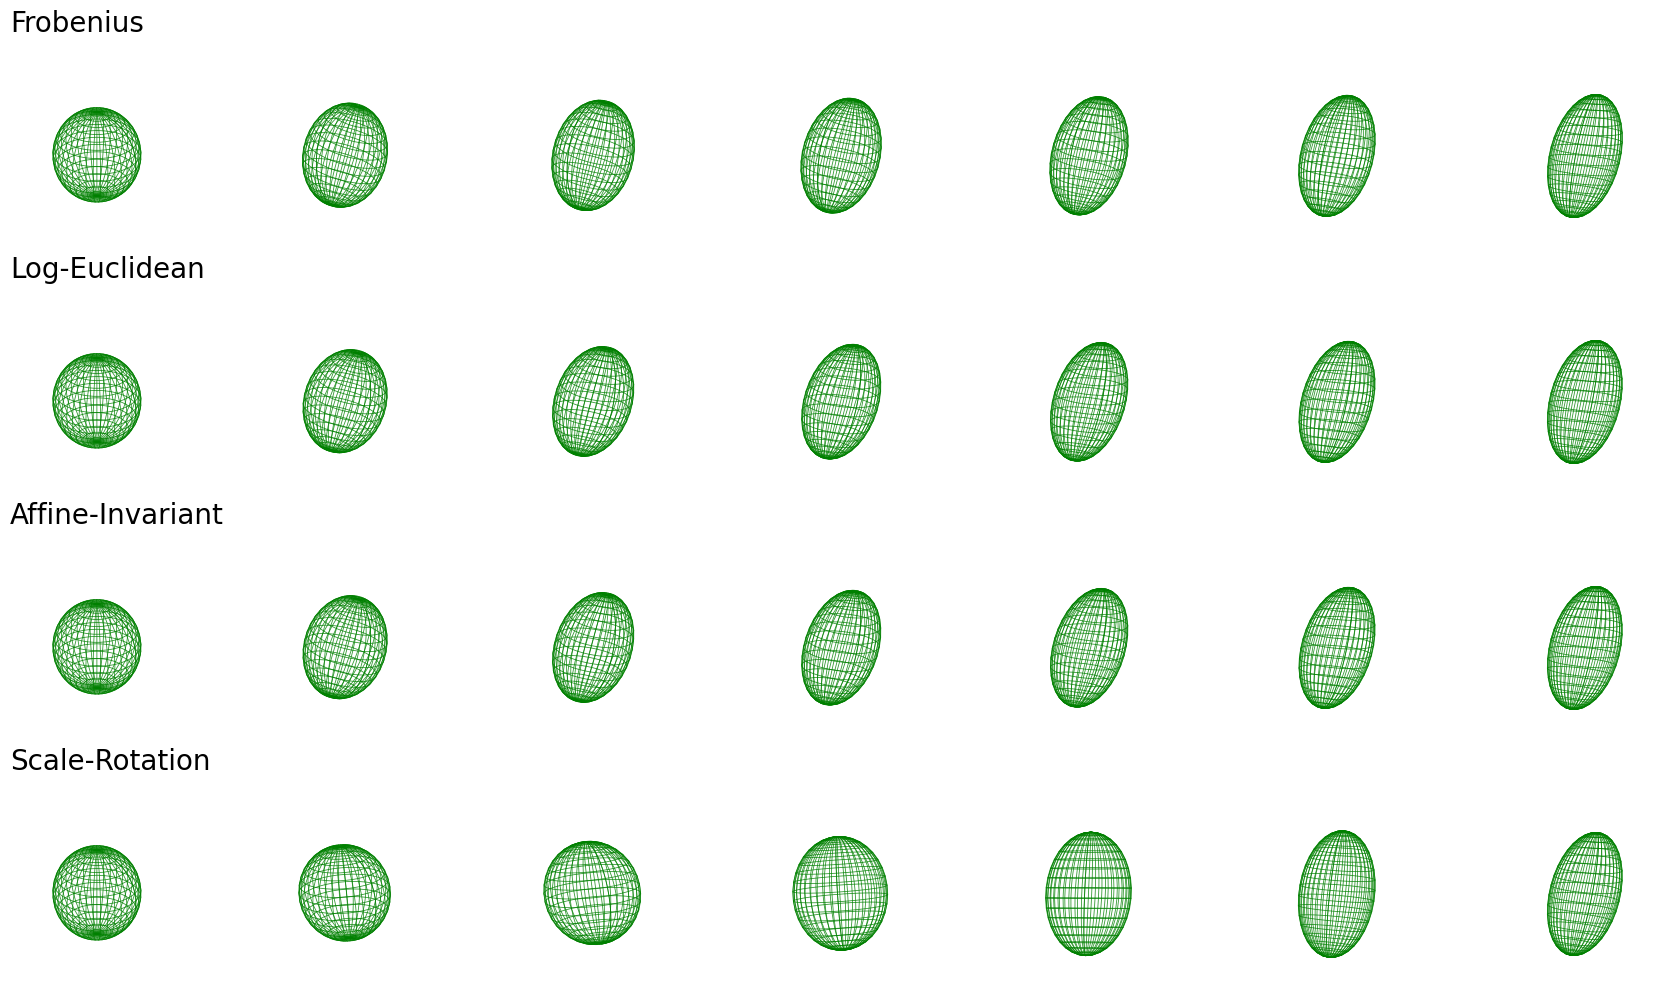

In [4]:
# Example Run: Construct two SPD(3) matrices
A = np.array([[1, 0, 0.0],
              [0, 1, 0],
              [0.0, 0, 1]])

B = np.array([[1.0, -0.5, 0.0],
              [-0.5, 2.5, 2],
              [0.0, 2, 2]])

plot_geodesic_grid(A, B, num=7)

In [5]:
S_end = curve_scale_rotation(A, B, t=1.0, k=1.0, force_B=True)
print("SR end equals B? ", np.allclose(S_end, B, rtol=1e-9, atol=1e-9))

SR end equals B?  True
